In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
plt.style.use('bmh')

In [5]:
from io import StringIO
import requests
import os

In [6]:
sales_data = pd.read_csv('PH-Sales.csv')  
sales_data.head(5)

,Month-Year,Number of Tractor Sold
0,Jan-03,141
1,Feb-03,157
2,Mar-03,185
3,Apr-03,199
4,May-03,203


In [7]:
# since the complete date was not mentioned, we assume that it was the first of every month
dates = pd.date_range(start='2003-01-01', freq='MS', periods=len(sales_data))
dates

DatetimeIndex(['2003-01-01', '2003-02-01', '2003-03-01', '2003-04-01',
               '2003-05-01', '2003-06-01', '2003-07-01', '2003-08-01',
               '2003-09-01', '2003-10-01',
               ...
               '2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01',
               '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01',
               '2014-11-01', '2014-12-01'],
              dtype='datetime64[ns]', length=144, freq='MS')

In [8]:
import calendar
sales_data['Month'] = dates.month

sales_data['Month'] = sales_data['Month'].apply(lambda x: calendar.month_abbr[x])

sales_data['Year'] = dates.year

sales_data.drop(['Month-Year'], axis=1, inplace=True)

sales_data.rename(columns={'Number of Tractor Sold':'Tractor-Sales'}, inplace=True)


sales_data = sales_data[['Month', 'Year', 'Tractor-Sales']]

# set the dates as the index of the dataframe, so that it can be treated as a 
# time-series dataframe
sales_data.set_index(dates, inplace=True)
sales_data.head(5)

,Month,Year,Tractor-Sales
2003-01-01,Jan,2003,141
2003-02-01,Feb,2003,157
2003-03-01,Mar,2003,185
2003-04-01,Apr,2003,199
2003-05-01,May,2003,203


Text(0, 0.5, 'Tractor Sales')

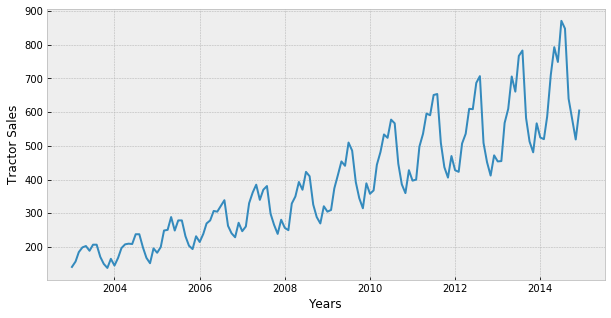

In [9]:
# extract out the time-series
sales_ts = sales_data['Tractor-Sales']
plt.figure(figsize=(10, 5))
plt.plot(sales_ts)
plt.xlabel('Years')
plt.ylabel('Tractor Sales')

## PH Trend - Time Series Decomposition

remove wrinkles from our time series using moving average. 
moving average of different time periods i.e. 4,6,8, and 12 months 


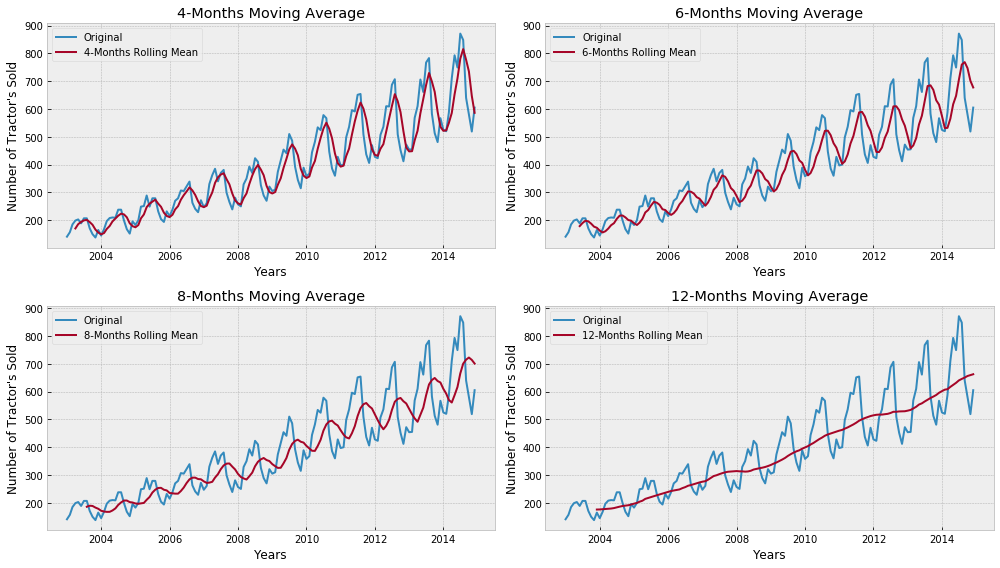

In [10]:
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)
axes[0][0].plot(sales_ts.index, sales_ts, label='Original')
axes[0][0].plot(sales_ts.index, sales_ts.rolling(window=4).mean(), label='4-Months Rolling Mean')
axes[0][0].set_xlabel("Years")
axes[0][0].set_ylabel("Number of Tractor's Sold")
axes[0][0].set_title("4-Months Moving Average")
axes[0][0].legend(loc='best')
axes[0][1].plot(sales_ts.index, sales_ts, label='Original')
axes[0][1].plot(sales_ts.index, sales_ts.rolling(window=6).mean(), label='6-Months Rolling Mean')
axes[0][1].set_xlabel("Years")
axes[0][1].set_ylabel("Number of Tractor's Sold")
axes[0][1].set_title("6-Months Moving Average")
axes[0][1].legend(loc='best')
axes[1][0].plot(sales_ts.index, sales_ts, label='Original')
axes[1][0].plot(sales_ts.index, sales_ts.rolling(window=8).mean(), label='8-Months Rolling Mean')
axes[1][0].set_xlabel("Years")
axes[1][0].set_ylabel("Number of Tractor's Sold")
axes[1][0].set_title("8-Months Moving Average")
axes[1][0].legend(loc='best')
axes[1][1].plot(sales_ts.index, sales_ts, label='Original')
axes[1][1].plot(sales_ts.index, sales_ts.rolling(window=12).mean(), label='12-Months Rolling Mean')
axes[1][1].set_xlabel("Years")
axes[1][1].set_ylabel("Number of Tractor's Sold")
axes[1][1].set_title("12-Months Moving Average")
axes[1][1].legend(loc='best')
plt.tight_layout()

12-month moving average produces a wrinkle free curve. There is expected monthly-seasonal effect in our data

 plot the rolling mean and standard deviation on window of 12 months.
 Determing rolling statistics

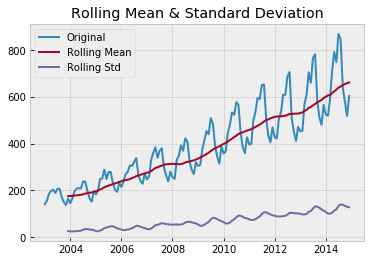

In [11]:
rolmean = sales_ts.rolling(window=12).mean()
rolstd = sales_ts.rolling(window=12).std()
#Plot rolling statistics:
orig = plt.plot(sales_ts, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean')
std = plt.plot(rolstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

# Dicky Fuller Test on the timeseries 

Run the Dicky Fuller Test on the timeseries and verify the null hypothesis that the TS is non-stationary.

In [12]:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   1.108825
p-value                          0.995291
#lags Used                      14.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


Though the variation in standard deviation is small, rolling mean is clearly increasing with time and this is not a stationary series.  we observe the moving average over months that there is a monhly pattern,

# PH Tractor Seasonality – Time Series Decomposition

The first thing to do is to see how number of tractors sold vary on a month on month basis. plot a stacked annual plot to observe seasonality


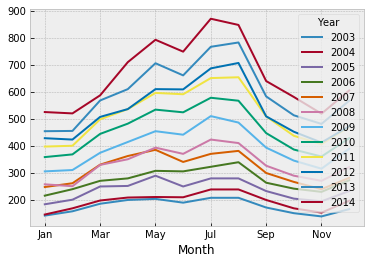

In [14]:
sales_data.head()

monthly_sales_data = pd.pivot_table(sales_data, values = "Tractor-Sales", columns = "Year", index = "Month")
monthly_sales_data


monthly_sales_data = monthly_sales_data.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
monthly_sales_data

monthly_sales_data.plot()

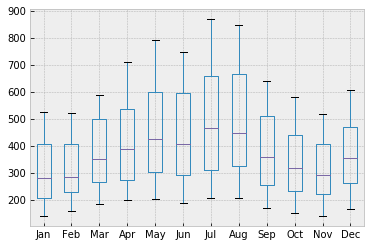

In [17]:
yearly_sales_data = pd.pivot_table(sales_data, values = "Tractor-Sales", columns = "Month", index = "Year")
yearly_sales_data = yearly_sales_data[['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
yearly_sales_data

yearly_sales_data.boxplot()

### Important Inferences

The tractor sales have been increasing without fail every year. July and August are the peak months for tractor sales and the variance and the mean value in July and August are also much higher than any of the other months.
We can see a seasonal cycle of 12 months where the mean value of each month starts with a increasing trend in the beginning of the year and drops down towards the end of the year. We can see a seasonal effect with a cycle of 12 months.


## PH Tractor Irregular Remainder

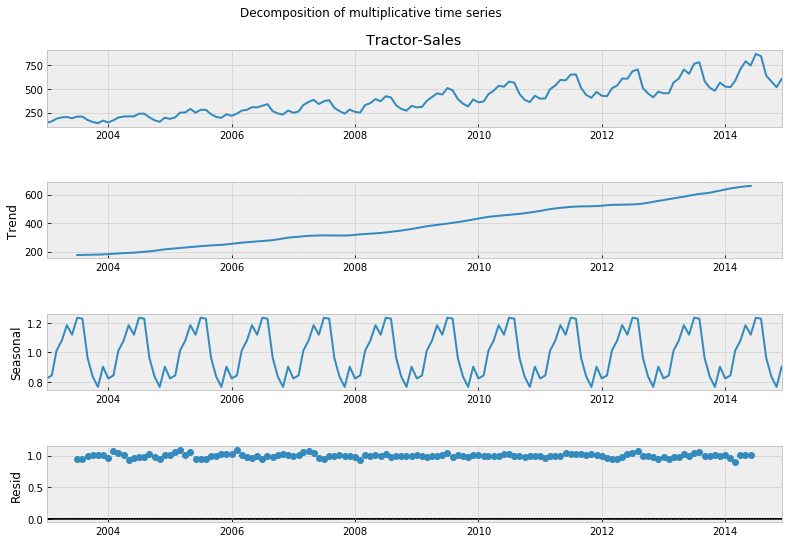

In [18]:
decomposition = sm.tsa.seasonal_decompose(sales_ts, model='multiplicative')
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

# PH Arima Modeling

In [19]:
# convert to a dataframe for easy plot and differenciation
random_df = pd.read_csv('dummy-sales.csv')
random_df.head(5)

,Month,Sales
0,1,266.0
1,2,145.9
2,3,183.1
3,4,119.3
4,5,180.3


In [20]:
random_df.set_index(pd.date_range(start='2012-01-01', freq='MS', periods=len(random_df)), inplace=True)
random_df.head(5)

,Month,Sales
2012-01-01,1,266.0
2012-02-01,2,145.9
2012-03-01,3,183.1
2012-04-01,4,119.3
2012-05-01,5,180.3


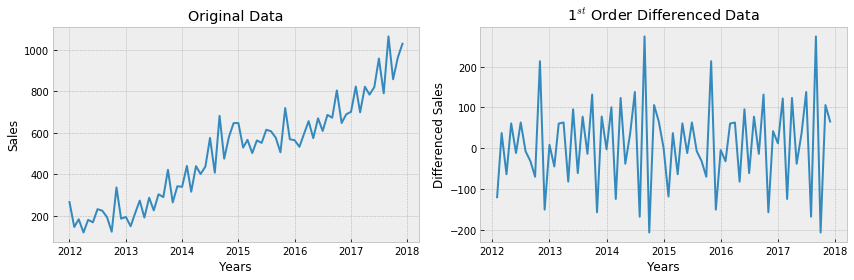

In [21]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
axes[0].plot(random_df.index, random_df['Sales'])
axes[0].set_xlabel("Years")
axes[0].set_ylabel("Sales")
axes[0].set_title("Original Data")
axes[1].plot(random_df.index, random_df['Sales'].diff(periods=1))
axes[1].set_xlabel("Years")
axes[1].set_ylabel("Differenced Sales")
axes[1].set_title("1$^{st}$ Order Differenced Data")
plt.tight_layout()
plt.show()

The residual data of most time series usually become trend-less after the first order differencing which is represented as ARIMA(0,1,0). 
Notice, AR (p), and MA (q) values in this notation are 0 and the integrated (I) value has order one. If the residual series still has a trend it is further differenced and is called 2nd order differencing. 
This trend-less series is called stationary on mean series i.e. mean or average value for series does not change over time.


## 2nd Pass of ARIMA to Extract Information

White Noise & Arim
generate white noise

In [22]:
np.random.seed(1)

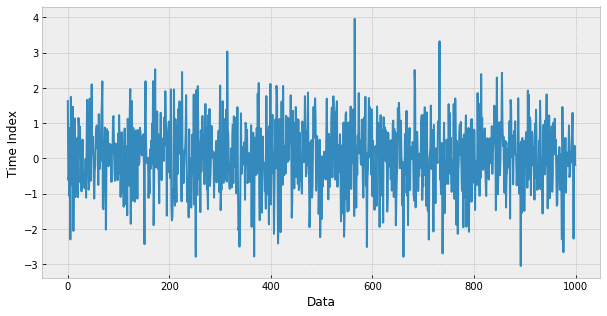

In [23]:
plt.figure(figsize=(10, 5))
white_noise = np.random.normal(size=1000)
plt.plot(white_noise)
plt.xlabel('Data')
plt.ylabel('Time Index')
plt.show()

plot of discrete white noise

<Figure size 432x288 with 0 Axes>

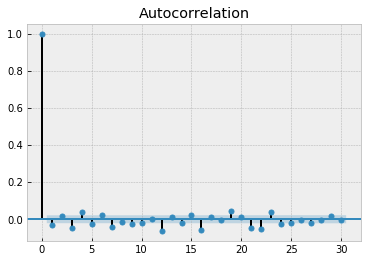

In [24]:
#ACF Plot
plt.figure()
smt.graphics.plot_acf(white_noise, lags=30, alpha=0.5)
plt.show()

### Step 2: Difference data to make data stationary on mean (remove trend)

Text(0, 0.5, 'Tractor Sales')

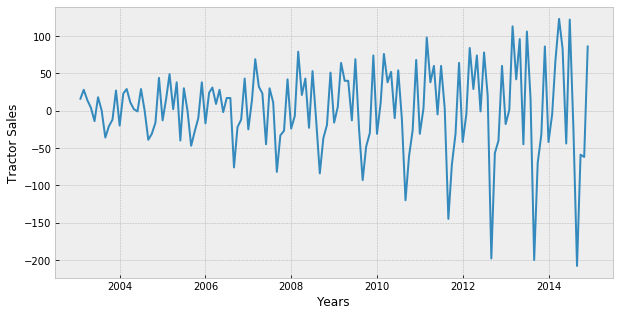

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(sales_ts.diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Tractor Sales')

Text(0, 0.5, 'Tractor Sales')

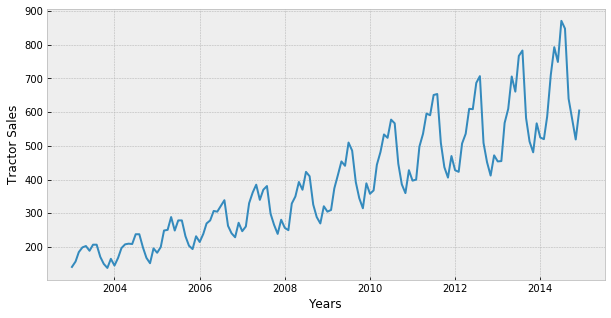

In [26]:
# original
plt.figure(figsize=(10, 5))
plt.plot(sales_ts)
plt.xlabel('Years')
plt.ylabel('Tractor Sales')

### Step 3: log transform data to make data stationary on variance

Text(0, 0.5, 'Log (Tractor Sales)')

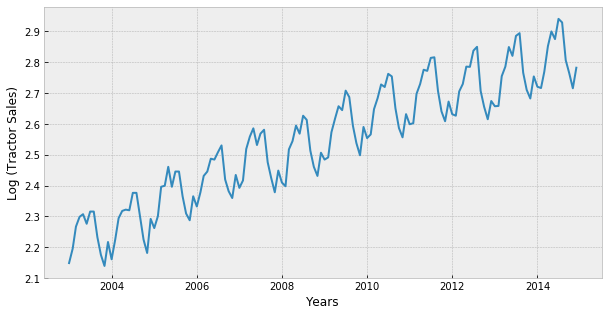

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(np.log10(sales_ts))
plt.xlabel('Years')
plt.ylabel('Log (Tractor Sales)')

### Step 4: Difference log transform data to make data stationary on both mean and variance 

Text(0, 0.5, 'Differenced Log (Tractor Sales)')

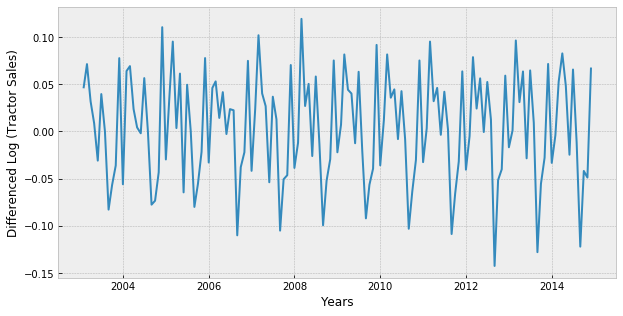

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(np.log10(sales_ts).diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Differenced Log (Tractor Sales)')

### Step 5: Plot ACF and PACF to identify potential AR and MA model

In [29]:
sales_ts_log = np.log10(sales_ts)
sales_ts_log.dropna(inplace=True)
sales_ts_log.head(5)

2003-01-01    2.149219
2003-02-01    2.195900
2003-03-01    2.267172
2003-04-01    2.298853
2003-05-01    2.307496
Freq: MS, Name: Tractor-Sales, dtype: float64

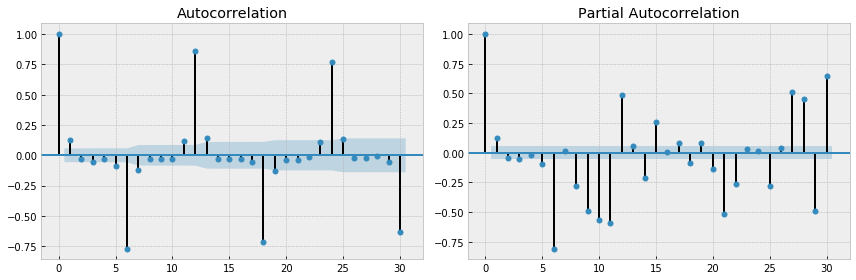

In [30]:
sales_ts_log_diff = sales_ts_log.diff(periods=1) # same as ts_log_diff = ts_log - ts_log.shift(periods=1)
sales_ts_log_diff.dropna(inplace=True)
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(sales_ts_log_diff, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(sales_ts_log_diff, lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()

### Step 6: Identification of best fit ARIMA model

Define the p, d and q parameters to take any value between 0 and 2

In [31]:
p = d = q = range(0, 2)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
print('pdq ', pdq)
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print(seasonal_pdq)

pdq  [(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
[(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]


In [32]:
import sys
warnings.filterwarnings("ignore") # specify to ignore warning messages
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None
for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(sales_ts_log,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(0, 1, 1)x(1, 0, 1, 12)12 model - AIC:-733.7746110341384


#### AIC & BIC

In [33]:
blog_param_order = (0, 1, 1)
blog_param_seasonal_order = (0, 1, 1, 12)
blog_model = sm.tsa.statespace.SARIMAX(sales_ts_log,
                                      order=blog_param_order,
                                      seasonal_order=blog_param_seasonal_order,
                                      enforce_stationarity=True,
                                      enforce_invertibility=True)
blog_results = blog_model.fit()
print("Blog SARIMAX{}x{}12 model - AIC:{}".format(blog_param_order, blog_param_seasonal_order, blog_results.aic))

Blog SARIMAX(0, 1, 1)x(0, 1, 1, 12)12 model - AIC:-702.7857534520094


### Step 7: Predict sales on in-sample date using the best fit ARIMA model

In [34]:
best_model = sm.tsa.statespace.SARIMAX(sales_ts_log,
                                      order=(0, 1, 1),
                                      seasonal_order=(1, 0, 1, 12),
                                      enforce_stationarity=True,
                                      enforce_invertibility=True)
best_results = best_model.fit()
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

                                     SARIMAX Results                                      
Dep. Variable:                      Tractor-Sales   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 370.887
Date:                            Sun, 09 Aug 2020   AIC                           -733.775
Time:                                    23:52:58   BIC                           -721.923
Sample:                                01-01-2003   HQIC                          -728.959
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3572      0.069     -5.191      0.000      -0.492      -0.222
ar.S.L12       0.9933      0.006   

In [35]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

Extract the predicted and true values of our time series

In [36]:
sales_ts_forecasted = pred_dynamic.predicted_mean
sales_ts_truth = sales_ts_log['2012-01-01':]
sales_ts_truth 

2012-01-01    2.631444
2012-02-01    2.626340
2012-03-01    2.705008
2012-04-01    2.729165
2012-05-01    2.785330
2012-06-01    2.784617
2012-07-01    2.836957
2012-08-01    2.849419
2012-09-01    2.706718
2012-10-01    2.655138
2012-11-01    2.614897
2012-12-01    2.673942
2013-01-01    2.657056
2013-02-01    2.658011
2013-03-01    2.754348
2013-04-01    2.785330
2013-05-01    2.848805
2013-06-01    2.820201
2013-07-01    2.884795
2013-08-01    2.893762
2013-09-01    2.765669
2013-10-01    2.710117
2013-11-01    2.682145
2013-12-01    2.753583
2014-01-01    2.720159
2014-02-01    2.716003
2014-03-01    2.768638
2014-04-01    2.851258
2014-05-01    2.899273
2014-06-01    2.874482
2014-07-01    2.940018
2014-08-01    2.928396
2014-09-01    2.806180
2014-10-01    2.764176
2014-11-01    2.715167
2014-12-01    2.781755
Freq: MS, Name: Tractor-Sales, dtype: float64

##### Compute the mean square error

In [37]:
mse = ((sales_ts_forecasted - sales_ts_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))

The Mean Squared Error of our forecasts is 0.0011


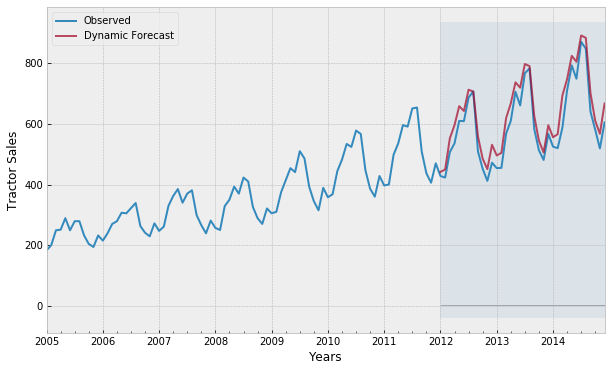

In [38]:
axis = sales_ts['2005':].plot(label='Observed', figsize=(10, 6))
np.power(10, pred_dynamic.predicted_mean).plot(ax=axis, label='Dynamic Forecast', alpha=0.7)
axis.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
axis.fill_betweenx(axis.get_ylim(), pd.to_datetime('2012-01-01'), sales_ts.index[-1], alpha=.1, zorder=-1)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')

### Step 8: Forecast sales using the best fit ARIMA model

In [39]:
n_steps = 36
pred_uc_99 = best_results.get_forecast(steps=36, alpha=0.01) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=36, alpha=0.05) # alpha=0.05 95% CI

Get confidence intervals 95% & 99% of the forecasts

In [40]:
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()
n_steps = 36
idx = pd.date_range(sales_ts.index[-1], periods=n_steps, freq='MS')
fc_95 = pd.DataFrame(np.column_stack([np.power(10, pred_uc_95.predicted_mean), np.power(10, pred_ci_95)]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([np.power(10, pred_ci_99)]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns
fc_all.head()

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
2014-12-01,567.460789,528.214060,609.623581,528.214060,609.623581
2015-01-01,566.203201,519.960342,616.558685,519.960342,616.558685
2015-02-01,668.831156,607.087374,736.854586,607.087374,736.854586
2015-03-01,755.202719,678.394298,840.707460,678.394298,840.707460
2015-04-01,850.217920,756.542873,955.491801,756.542873,955.491801


#### plot the forecast along with the confidence band

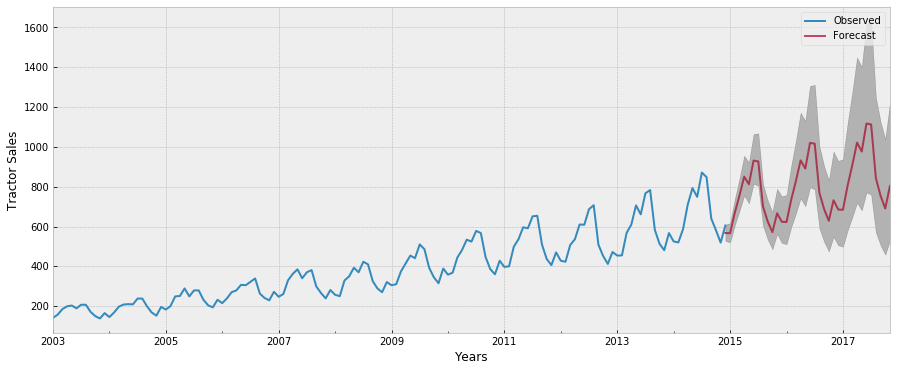

In [41]:
axis = sales_ts.plot(label='Observed', figsize=(15, 6))
fc_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='k', alpha=.25)
#axis.fill_between(fc_all.index, fc_all['lower_ci_99'], fc_all['upper_ci_99'], color='k', alpha=.75)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()

### Step 9: Plot ACF and PACF for residuals of ARIMA model to ensure no 

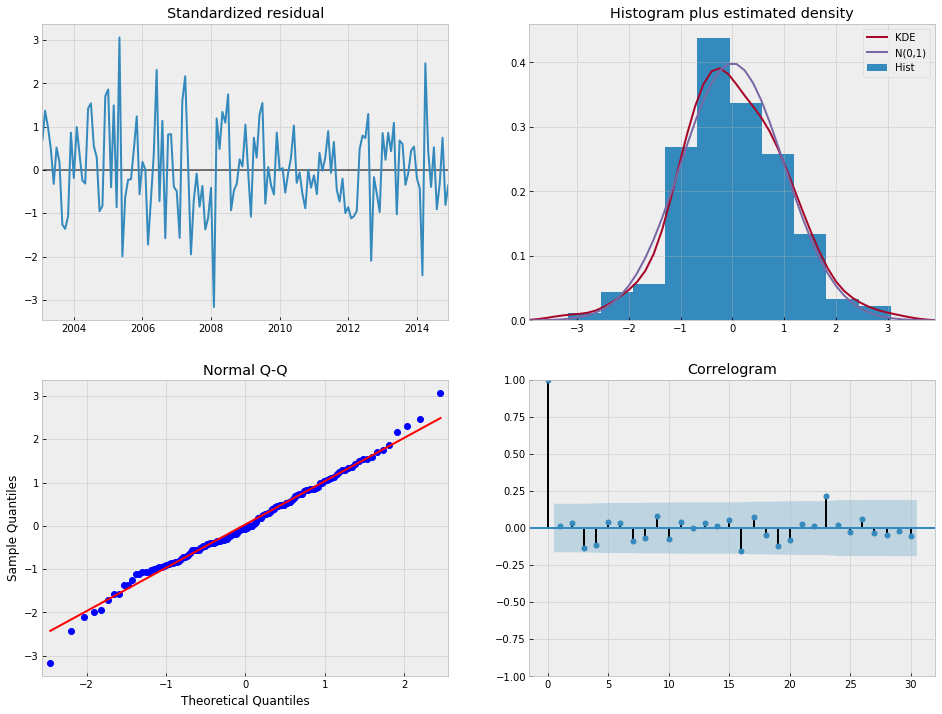

In [42]:
best_results.plot_diagnostics(lags=30, figsize=(16,12))
plt.show()

### Step 10: Regression with ARIMA Errors 

In [43]:
mkt_sales_data = pd.read_csv('sales-and-marketing.csv')
mkt_sales_data.head()

,Time Period,Sales,Marketing Expense
0,Jan-11,397,486.64
1,Feb-11,400,501.80
2,Mar-11,498,437.09
3,Apr-11,536,565.16
4,May-11,596,744.15


In [44]:
# since the complete date was not mentioned, assume that it was the first of every month
mkt_sales_data.set_index(pd.date_range(start='2011-01-01', freq='MS', periods=len(mkt_sales_data)), inplace=True)
mkt_sales_data.drop(['Time Period'], axis=1, inplace=True)
mkt_sales_data.rename(columns={'Sales':'Tractor-Sales'}, inplace=True)
mkt_sales_data.head(5)

,Tractor-Sales,Marketing Expense
2011-01-01,397,486.64
2011-02-01,400,501.80
2011-03-01,498,437.09
2011-04-01,536,565.16
2011-05-01,596,744.15


plot the following scatter plot of same months marketing expense and tractors sales.

Correlation for Marketing Data: 0.8


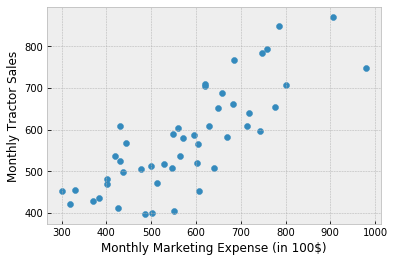

In [45]:
plt.figure()
plt.scatter(x=mkt_sales_data['Marketing Expense'], y=mkt_sales_data['Tractor-Sales'])
plt.xlabel('Monthly Marketing Expense (in 100$)')
plt.ylabel('Monthly Tractor Sales')

print("Correlation for Marketing Data: {}".format(round(mkt_sales_data.corr()['Marketing Expense']['Tractor-Sales'], 2)))
# The following is the correlation plot for stationary data:

Correlation for Stationary Data: 0.41


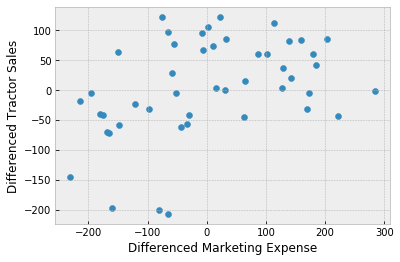

In [46]:
mkt_sales_data_diff = mkt_sales_data.diff(periods=1)
mkt_sales_data_diff.dropna(inplace=True)
mkt_sales_data_diff.head()

plt.figure()
plt.scatter(x=mkt_sales_data_diff['Marketing Expense'], y=mkt_sales_data_diff['Tractor-Sales'])
plt.xlabel('Differenced Marketing Expense')
plt.ylabel('Differenced Tractor Sales')


print("Correlation for Stationary Data: {}".format(round(mkt_sales_data_diff.corr()['Marketing Expense']['Tractor-Sales'], 2)))

near perfect correlation has now disappeared though there is still some correlation in this data ( ρ  = 0.41).
Typically, the marketing effort for the previous few months needs to have a good correlation with sales for an effective marketing program. 

In [48]:
print(len(mkt_sales_data_diff))
prev_months_corr_data = pd.DataFrame(np.column_stack((\
                                        mkt_sales_data_diff['Marketing Expense'][0:46].values,\
                                        mkt_sales_data_diff['Tractor-Sales'][1:47].values)), \
                                     columns=["Previous Month's Differenced Marketing Expense" , 
                                              "Differenced Tractor Sales"])
prev_months_corr_data.head()

47


,Previous Month's Differenced Marketing Expense,Differenced Tractor Sales
0,15.16,98.0
1,-64.71,38.0
2,128.07,60.0
3,178.99,-5.0
4,-195.41,60.0


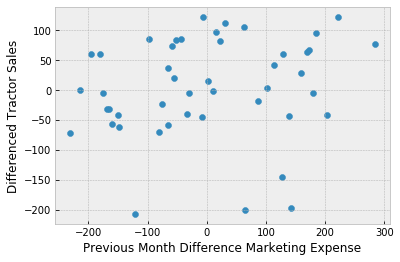

Correlation of current Months's Differenced Tractor Sales with Previous Month's Differenced Marketing Expense: 0.17


In [49]:
plt.figure()
plt.scatter(x=prev_months_corr_data["Previous Month's Differenced Marketing Expense"], \
            y=prev_months_corr_data["Differenced Tractor Sales"])
plt.xlabel("Previous Month Difference Marketing Expense")
plt.ylabel("Differenced Tractor Sales")
plt.show()
print(
    "Correlation of current Months's Differenced Tractor Sales with Previous Month's Differenced Marketing Expense: {}"\
    .format(round(prev_months_corr_data.corr().iloc[0,1], 2)))


The following diagram how the current data can be correlated to the previous months data.
Previous Months Correlation The correlation for the previous quarter also shows non-existent correlation with sales. build a regression model with ARIMA error (ARIMAX) model for the current and previous months.

In [50]:
clip_length = len(mkt_sales_data_diff)
clip_length

47

In [51]:
lagged_mkt_exp_diff_sales_data = pd.DataFrame(np.column_stack((\
                                        mkt_sales_data_diff['Marketing Expense'],\
                                        mkt_sales_data_diff['Marketing Expense'].shift(periods=1)[0:clip_length],\
                                        mkt_sales_data_diff['Marketing Expense'].shift(periods=2)[0:clip_length],\
                                        mkt_sales_data_diff['Marketing Expense'].shift(periods=3)[0:clip_length],\
                                        mkt_sales_data_diff['Tractor-Sales'][0:47].values)), \
                                     columns=["Diff_Mkt_Exp", "Diff_Mkt_Exp_Lag_1", "Diff_Mkt_Exp_Lag_2", "Diff_Mkt_Exp_Lag_3", "Diff_Sales"])
lagged_mkt_exp_diff_sales_data.head(5)

,Diff_Mkt_Exp,Diff_Mkt_Exp_Lag_1,Diff_Mkt_Exp_Lag_2,Diff_Mkt_Exp_Lag_3,Diff_Sales
0,15.16,NaN,NaN,NaN,3.0
1,-64.71,15.16,NaN,NaN,98.0
2,128.07,-64.71,15.16,NaN,38.0
3,178.99,128.07,-64.71,15.16,60.0
4,-195.41,178.99,128.07,-64.71,-5.0


In [52]:
lagged_mkt_exp_diff_sales_data.set_index(mkt_sales_data_diff.index, inplace=True)
lagged_mkt_exp_diff_sales_data.head(5)

,Diff_Mkt_Exp,Diff_Mkt_Exp_Lag_1,Diff_Mkt_Exp_Lag_2,Diff_Mkt_Exp_Lag_3,Diff_Sales
2011-02-01,15.16,NaN,NaN,NaN,3.0
2011-03-01,-64.71,15.16,NaN,NaN,98.0
2011-04-01,128.07,-64.71,15.16,NaN,38.0
2011-05-01,178.99,128.07,-64.71,15.16,60.0
2011-06-01,-195.41,178.99,128.07,-64.71,-5.0


The marketing expense for the last month as displayed below has very little correlation ( ρ  = 0.17):


We now want to create different by considering the different lagged marketing expenditure attributes as regressors and investigate whether previous 
motnh's/quarter's affect the tractor sales or not (in other words if we incoporate the marketing efforts does they lower the AIC score or not.
We would be building 4 ARIMA models with regressors ranging from current month to last quarter) Models With Regressors


In [53]:
def auto_arima(timeseries, regressors=None, p=range(0, 2), d=range(0, 1), q=range(0, 2)):

    # Generate all different combinations of p, d and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    
    warnings.filterwarnings("ignore") # specify to ignore warning messages

    best_aic = np.inf
    best_pdq = None
    best_seasonal_pdq = None
    best_results = None

    for param in pdq:
        for param_seasonal in seasonal_pdq:

            try:
                temp_model = sm.tsa.statespace.SARIMAX(endog=timeseries,
                                                 exog=regressors,
                                                 order = param,
                                                 seasonal_order = param_seasonal,
                                                 enforce_stationarity=True,
                                                 enforce_invertibility=True)
                temp_results = temp_model.fit()

                # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
                if temp_results.aic < best_aic:
                    best_aic = temp_results.aic
                    best_pdq = param
                    best_seasonal_pdq = param_seasonal
                    best_results = temp_results
            except:
                #print("Unexpected error:", sys.exc_info()[0])
                continue
                
                

    print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))
    print(best_results.summary().tables[0])
    print(best_results.summary().tables[1])


In [54]:
lagged_mkt_exp_diff_sales_data.head()

lagged_mkt_exp_diff_sales_data["Diff_Sales"].head()

#ARIMA Model No Regressor
timeseries = lagged_mkt_exp_diff_sales_data["Diff_Sales"][3:47]
timeseries.head()

regressors = lagged_mkt_exp_diff_sales_data["Diff_Mkt_Exp"][3:47]
regressors.head()

auto_arima(timeseries, regressors, p=range(0, 2), d=range(0, 1), q=range(0, 2))

Best SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 model - AIC:443.25444779657226
                                      SARIMAX Results                                      
Dep. Variable:                          Diff_Sales   No. Observations:                   44
Model:             SARIMAX(0, 0, 1)x(1, 0, [], 12)   Log Likelihood                -217.627
Date:                             Mon, 10 Aug 2020   AIC                            443.254
Time:                                     00:05:58   BIC                            450.391
Sample:                                 05-01-2011   HQIC                           445.901
                                      - 12-01-2014                                         
Covariance Type:                               opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Diff_Mkt_Exp     0.0233      0.03

### ARIMA Model with 1 month Lag Marekting Sales Data Regressor

In [55]:
timeseries = lagged_mkt_exp_diff_sales_data["Diff_Sales"][3:47]
regressors = lagged_mkt_exp_diff_sales_data[["Diff_Mkt_Exp", "Diff_Mkt_Exp_Lag_1"]][3:47]
auto_arima(timeseries, regressors, p=range(0, 2), d=range(0, 1), q=range(0, 2))

Best SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 model - AIC:445.14005346655085
                                      SARIMAX Results                                      
Dep. Variable:                          Diff_Sales   No. Observations:                   44
Model:             SARIMAX(0, 0, 1)x(1, 0, [], 12)   Log Likelihood                -217.570
Date:                             Mon, 10 Aug 2020   AIC                            445.140
Time:                                     00:06:40   BIC                            454.061
Sample:                                 05-01-2011   HQIC                           448.448
                                      - 12-01-2014                                         
Covariance Type:                               opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Diff_Mkt_Exp         

### ARIMA Model with 2 months Lag Marekting Sales Data Regressor

In [56]:
timeseries = lagged_mkt_exp_diff_sales_data["Diff_Sales"][3:47]
regressors = lagged_mkt_exp_diff_sales_data[["Diff_Mkt_Exp", "Diff_Mkt_Exp_Lag_1", "Diff_Mkt_Exp_Lag_2"]][3:47]
auto_arima(timeseries, regressors, p=range(0, 2), d=range(0, 1), q=range(0, 2))

Best SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 model - AIC:447.0778379631544
                                      SARIMAX Results                                      
Dep. Variable:                          Diff_Sales   No. Observations:                   44
Model:             SARIMAX(0, 0, 1)x(1, 0, [], 12)   Log Likelihood                -217.539
Date:                             Mon, 10 Aug 2020   AIC                            447.078
Time:                                     00:07:15   BIC                            457.783
Sample:                                 05-01-2011   HQIC                           451.048
                                      - 12-01-2014                                         
Covariance Type:                               opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Diff_Mkt_Exp          

### ARIMA Model with 3 months Lag Marekting Sales Data Regressor

In [57]:
timeseries = lagged_mkt_exp_diff_sales_data["Diff_Sales"][3:47]
regressors = lagged_mkt_exp_diff_sales_data[["Diff_Mkt_Exp", "Diff_Mkt_Exp_Lag_1", "Diff_Mkt_Exp_Lag_2", "Diff_Mkt_Exp_Lag_3"]][3:47]
auto_arima(timeseries, regressors, p=range(0, 2), d=range(0, 1), q=range(0, 2))

Best SARIMAX(1, 0, 0)x(1, 0, 0, 12)12 model - AIC:447.40320160140436
                                     SARIMAX Results                                      
Dep. Variable:                         Diff_Sales   No. Observations:                   44
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -216.702
Date:                            Mon, 10 Aug 2020   AIC                            447.403
Time:                                    00:07:48   BIC                            459.893
Sample:                                05-01-2011   HQIC                           452.035
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Diff_Mkt_Exp           0.0111

# Statespace Model Results 

Compare the AIC from the various models

     Models       No Regressor    1 Month Lag Regressor    2 Months Lag Regressor     3 Months Lag Regressor
       AIC           443.254            445.140                    447.078                   447.403


Notice AIC, AICc, and BIC values for the plain ARIMA model without marketing expense 
as predictor variable has lower values of the two models. 

This indicates that marketing expense is not actually adding value to tractor sales.

This is the first indication for the management at PH to re-evaluate the marketing 
and farmer connect program. 